## Physics Informed Neural Networks to find Eigenfunctions and values of PDEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import time
import copy
torch.autograd.set_detect_anomaly(True)
#torch.set_num_threads(8)
#torch.set_num_interop_threads(8)

intra_op_t = torch.get_num_interop_threads()
inter_op_t = torch.get_num_threads()

seed = 120
torch.manual_seed(seed)
np.random.seed(seed)

type_ = torch.float32

print(f"Intra op threds: {intra_op_t}\nInter op threds: {inter_op_t}")

Intra op threds: 8
Inter op threds: 8


In [2]:
class Sin(nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

class NeuralNet(nn.Module):

    def __init__(self, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        self.neurons = neurons
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = Sin()
        
        # determine symmetry
        self.sym = -1
        
        self.layer_I = nn.Linear(1,1)
        self.input_layer = nn.Linear(2, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons + 1, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons + 1, 1)
        self.init_xavier()

    def forward(self, x):
        x = x.reshape(-1,1)
        lambda_ = self.layer_I(torch.ones_like(x)).reshape(-1,1)
        lambda_ = lambda_

        x_plus = x
        x_plus = torch.cat((x_plus, lambda_), dim=1)
        x_plus = self.activation(self.input_layer(x_plus))
        for _, l in enumerate(self.hidden_layers):
            x_plus = torch.cat((x_plus, lambda_), dim=1)
            x_plus = self.activation(l(x_plus))

        x_minus = -x
        x_minus = torch.cat((x_minus, lambda_), dim=1)
        x_minus = self.activation(self.input_layer(x_minus))
        for _, l in enumerate(self.hidden_layers):
            x_minus = torch.cat((x_minus, lambda_), dim=1)
            x_minus = self.activation(l(x_minus))
        
        hub_layer = torch.cat((x_plus + self.sym * x_minus, lambda_), dim=1)
        return self.output_layer(hub_layer), lambda_

    def init_xavier(self):
        def init_weights(m):
            # dont reset the lambda layer
            if type(m) == nn.Linear and m.weight.shape[0] != 1:
                torch.nn.init.xavier_uniform_(m.weight.data)

        self.apply(init_weights)

In [3]:
def plot(lambda_hist, pde_hist, norm_hist, orth_hist, f, input):
    plt.close()
    fig, axs = plt.subplots(1,4, figsize=(12,6))
    input = input.flatten().detach().numpy()
    f = f.flatten().detach().numpy()
    idx = np.argsort(input)
    input = input[idx]
    f = f[idx]
    axs[0].plot(lambda_hist)
    axs[0].set_title('Lambda n')
    axs[1].semilogy(pde_hist)
    axs[1].set_title('PDE Loss')
    axs[2].semilogy(norm_hist)
    axs[2].set_title('Norm Loss')
    axs[3].semilogy(orth_hist)
    axs[3].set_title('Orth Loss')

    fig.tight_layout()
    fig.savefig("./plots/losses.png")

    plt.close()
    plt.cla()
    plt.plot(input, f)
    plt.tight_layout()
    plt.savefig("./plots/fig.png")


In [4]:
def compute_pde_residual(input: torch.Tensor, f: torch.Tensor, lam: torch.Tensor) -> torch.Tensor:
    """Compute residual

    Args:
        input (torch.Tensor): input points
        f (torch.Tensor): function values at input
        lam (torch.tensor): containting the eigenvalue

    Returns:
        torch.Tensor: residual values
    """
    assert(f.shape == input.shape)
    
    grad_x = torch.autograd.grad(f.sum(), input, create_graph=True)[0].reshape(-1,1)
    grad_xx = torch.autograd.grad(grad_x.sum(), input, create_graph=True)[0].reshape(-1,1)

    assert(f.shape == grad_x.shape)

    pde_residual = grad_xx + (lam.pow(2)) * f
    return pde_residual.reshape(-1, 1)
        
# function computing the solution from x and the neural net output
def para_f(x : torch.Tensor, N : torch.Tensor, L : float) -> torch.Tensor:
    """computes parametized solution form input points x and nonparametrized values N

    Args:
        x (torch.Tensor): input points
        N (torch.Tensor): nonparametrized solution 
        L (float): endpoint

    Returns:
        torch.Tensor: parametrized solution
    """
    assert(x.shape == N.shape)
    g = (1 - torch.exp(-x)) * (1 - torch.exp(-(x - L)))
        
    return N * g


################################################################################################
def fit(num_epochs : int, 
        layers : int,
        neurons : int, 
        lr : float, 
        n_points : int, 
        L : float, 
        inv_verbosity : int,
        solutions = list(),
        ):

    # log
    loss_history = list()
    pde_loss_history = list()
    orth_loss_history = list()
    norm_loss_history = list()
    lambda_history = list()
    orth_cnt = 0
    orth_epoch = 0
    
    # storages
    temp_solutions = []
    
    # neural net
    nn = NeuralNet(n_hidden_layers=layers, neurons=neurons)
    nn.init_xavier()
    
    # optimizer
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(nn.parameters(), lr=lr, betas=betas)

    # train
    time0 = time.time()

    # Loop over epochs
    for epoch in range(num_epochs):
        
        # counter within one orthogonal solution
        orth_epoch += 1

        # redrt gradients
        optimizer.zero_grad()
        
        # assemble points
        input = torch.linspace(0,L, n_points)
        noise = L / n_points * torch.randn_like(input) * 0.09
        input = input + noise
        
        # permute input
        pert = np.random.permutation(n_points)
        input = input[pert]
        input = input.reshape(-1,1)
        input.requires_grad = True
            
        # compute apporximation
        N, lam = nn.forward(input)
        f = para_f(input, N, L)
        lam = torch.abs(lam[0])

        # PDE loss
        r_pde = compute_pde_residual(input=input, f=f, lam=lam)
        l_pde = r_pde.pow(2).mean()
        loss = l_pde
            
        # Normalization Loss
        lnorm = (torch.dot(lam * f.flatten(),lam * f.flatten()).sqrt() - n_points / L).pow(2)
        loss += lnorm
            
        # Orthogonal loss and lambda loss
        psi_eigen = torch.zeros_like(input).type(type_)
        for nn_orth, _, _, _ in solutions:
            N_orth, _ = nn_orth.forward(input)
            f_orth = para_f(input, N_orth, L)
            psi_eigen += f_orth
            
        lorth =  0.02 * torch.dot(psi_eigen.flatten(),f.flatten()).pow(2).sqrt()
        if len(solutions) > 0:
            loss += lorth

        # update network
        loss.backward(retain_graph=False)
        optimizer.step()
        
        # write logs
        loss_history.append(loss.item())
        pde_loss_history.append(l_pde.item())
        orth_loss_history.append(lorth.item())
        norm_loss_history.append(lnorm.item())
        lambda_history.append(lam.item())

        # Compute stopping criterion
        window = 1000
        mov_avg = 0
        if len(pde_loss_history) >= window + 1:
            mov_avg = np.mean(np.array(pde_loss_history)[-window:] - np.array(pde_loss_history)[-window-1:-1])
        else:
            mov_avg = np.mean(np.array(pde_loss_history)[1:] - np.array(pde_loss_history)[:-1])
                
        # change criteria if threshold is reached
        lambda_idx = int(np.round(lam.item(), 0))

        thresh = np.exp(-10)
        if orth_epoch == 1.5e4 or (mov_avg < thresh and mov_avg > 0):
            if orth_cnt in [0]:
                nn.init_xavier()
            
            if orth_cnt in [3]:
                nn.sym *= -1
            
            if orth_cnt in [0, 1, 2, 5]:
                solutions.append(temp_solutions[lambda_idx])

            orth_cnt = orth_cnt + 1
            orth_epoch = 0

        if len(temp_solutions) <= lambda_idx:
            temp_solutions.append((copy.deepcopy(nn), lam.item(), l_pde, epoch))
        elif l_pde.item() < temp_solutions[lambda_idx][2]:
            temp_solutions[lambda_idx] = [copy.deepcopy(nn), lam.item(), l_pde, epoch]

        # print losses of the current epoch
        if epoch % inv_verbosity == 0: 
            print(f"epoch {epoch}: orth sol {orth_cnt}| Total loss: ", format(loss.item(),'.5f'), 
                    "| mavg: ", format(mov_avg,'.7f'), 
                    "| lam: ", format(lam.item(),'.6f'), 
                    "| lpde: ", format(l_pde.item(),'.4f'), 
                    "| lnorm: ", format(lnorm.item(),'.4f'), 
                    "| lorth: ", format(lorth.item(),'.4f'))
            plot(lambda_history, pde_loss_history, norm_loss_history, orth_loss_history, f, input)
            
        if orth_cnt == 6:
            return loss_history, pde_loss_history, orth_loss_history,\
                norm_loss_history, lambda_history, solutions, neurons, layers


    time1 = time.time()
    print('Final Loss: ', loss_history[-1], ' in ', time0 - time1, " seconds" )

    return loss_history, pde_loss_history, orth_loss_history,\
        norm_loss_history, lambda_history, solutions, neurons, layers



In [5]:
def resotre_solutions(path : str):
    solutions = list()
    dic = torch.load(path)
    layers = dic["layer"]
    neurons = dic["neurons"]
    last_lambda = 0
    for state in dic["solutions"]:
        nn = NeuralNet(layers,neurons,0)
        nn.load_state_dict(state)
        nn.min_lambda = last_lambda
        _, lam = nn.forward(torch.zeros((1,1)))
        last_lambda = lam.item()
        solutions.append(nn)
    return solutions, last_lambda

epoch 0: orth sol 0| Total loss:  258301.59375 | mavg:  nan | lam:  0.274587 | lpde:  258301.5938 | lnorm:  258301.1875 | lorth:  0.0000


/home/nico/miniconda3/envs/dlsc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/dlsc/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/tmp/ipykernel_386220/3828232638.py:18: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.tight_layout()


epoch 300: orth sol 0| Total loss:  1837.83887 | mavg:  -854.8791829 | lam:  1.991126 | lpde:  1837.8389 | lnorm:  663.3187 | lorth:  0.0000
epoch 600: orth sol 0| Total loss:  3524.94238 | mavg:  -424.6277523 | lam:  2.217613 | lpde:  3524.9424 | lnorm:  1890.5034 | lorth:  0.0000
epoch 900: orth sol 0| Total loss:  2652.05859 | mavg:  -284.0550391 | lam:  2.225049 | lpde:  2652.0586 | lnorm:  1402.2771 | lorth:  0.0000
epoch 1200: orth sol 0| Total loss:  1035.64917 | mavg:  -0.8443334 | lam:  2.164695 | lpde:  1035.6492 | lnorm:  71.4858 | lorth:  0.0000
epoch 1500: orth sol 0| Total loss:  1474.94165 | mavg:  -3.3901980 | lam:  2.110792 | lpde:  1474.9417 | lnorm:  749.8234 | lorth:  0.0000
epoch 1800: orth sol 0| Total loss:  698.69153 | mavg:  -0.6497126 | lam:  2.025045 | lpde:  698.6915 | lnorm:  288.0110 | lorth:  0.0000
epoch 2100: orth sol 0| Total loss:  760.33868 | mavg:  -1.6675837 | lam:  1.970592 | lpde:  760.3387 | lnorm:  447.3532 | lorth:  0.0000
epoch 2400: orth sol

KeyboardInterrupt: 

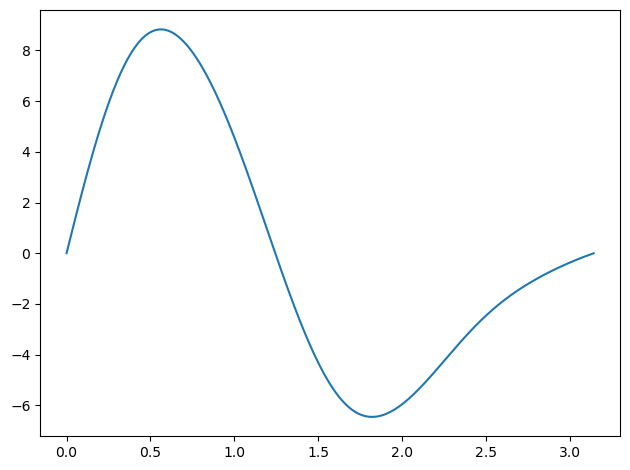

In [6]:
#solutions, last_lambda = resotre_solutions("last_training_.pt")[:3]
loss_hist, pde_loss_hist, orth_loss_hist, norm_loss_hist,\
    lambda_hist, solutions, neurons, layer = fit(num_epochs=80000, 
           layers=1, 
           neurons=10, 
           lr=1e-2, 
           n_points=1600,
           L = np.pi,
           inv_verbosity=300,
           #solutions = solutions,
           #last_lambda=last_lambda
            )


In [ ]:
# save solutions
solutions_state = [sol.state_dict() for sol in solutions]
train_dic = {"pde_loss":pde_loss_hist,
             "orth_loss":orth_loss_hist,
             "norm_loss":norm_loss_hist,
             "lam_hist": lambda_hist,
             "neurons": neurons,
             "layer": layer,
             "solutions":solutions_state
             }
torch.save(train_dic, "last_training.pt")

AttributeError: 'list' object has no attribute 'state_dict'

<function matplotlib.pyplot.show(close=None, block=None)>

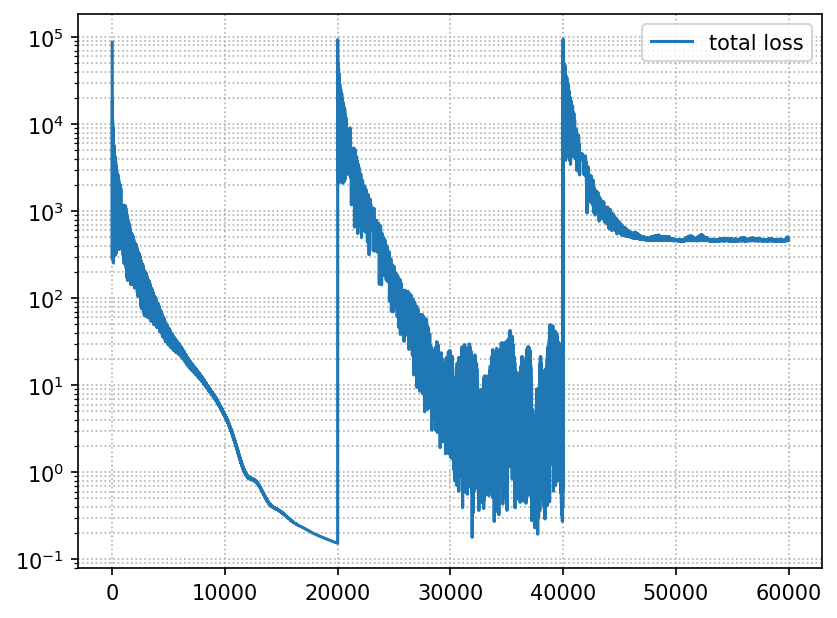

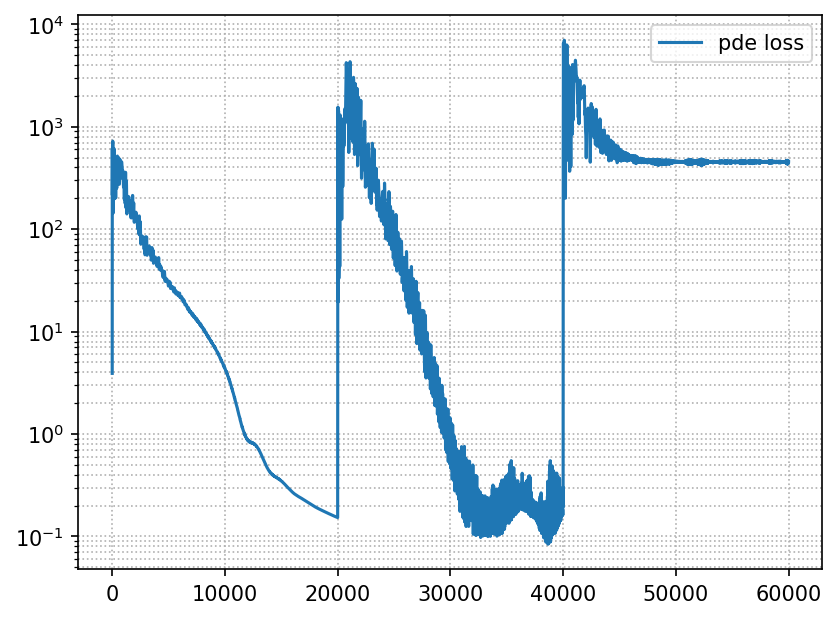

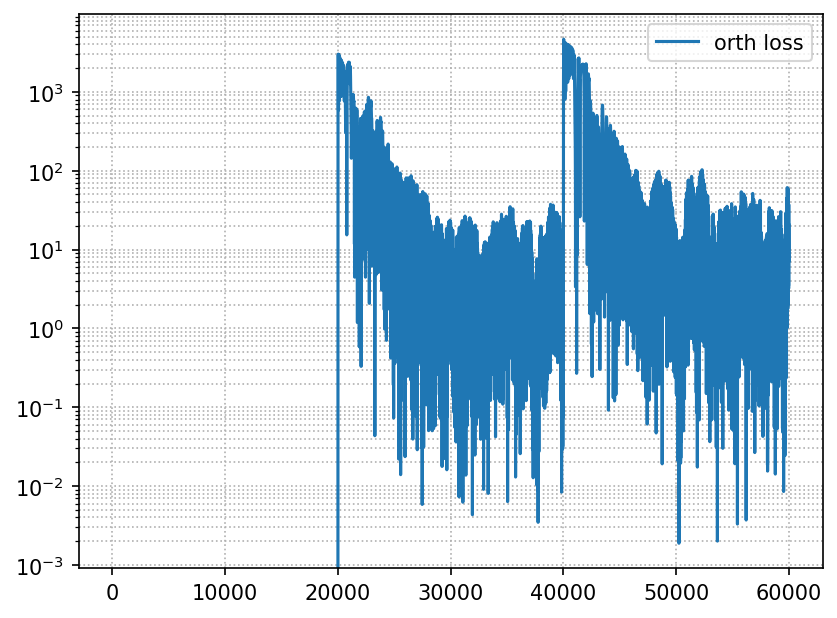

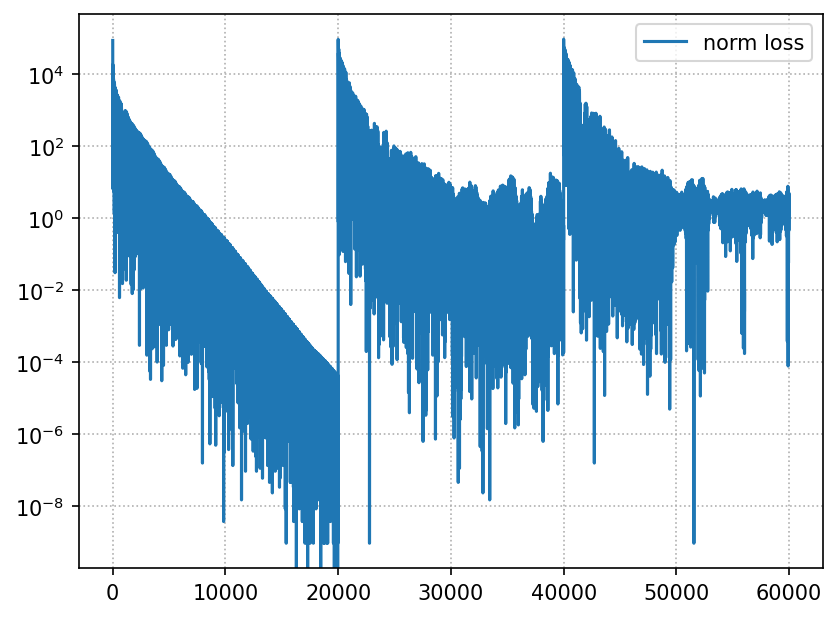

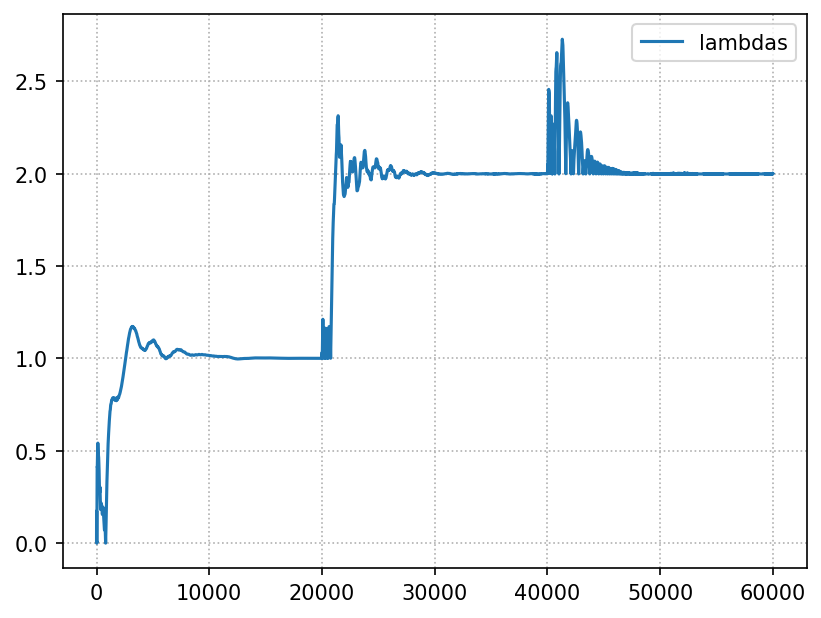

In [ ]:

losses = [(loss_hist, "total loss"), 
          (pde_loss_hist, "pde loss"), 
          (orth_loss_hist, "orth loss"), 
          (norm_loss_hist, "norm loss")]

for loss, titel in losses:
    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(loss) + 1), loss, label=titel)
    plt.yscale("log")
    plt.legend()
    plt.show

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(lambda_hist) + 1), lambda_hist, label="lambdas")
#plt.yscale("log")
plt.legend()
plt.show

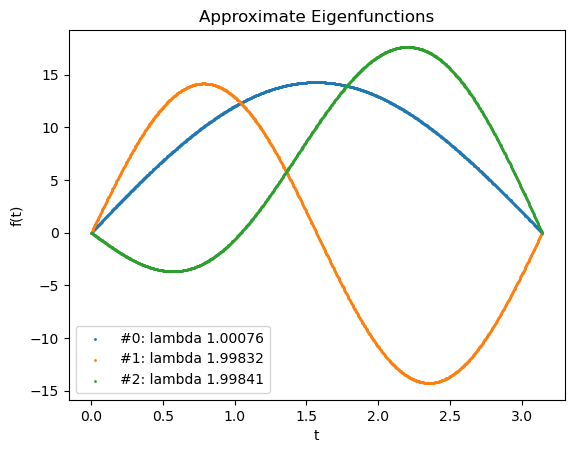

In [ ]:
def plotting(solutions):
    inputs = torch.linspace(0, 1, steps=1000)
    inputs = inputs.reshape(-1,1)
    inputs = np.pi * inputs

    for i, sol in enumerate(solutions):
        nn = sol
        N, lam = nn(inputs)
        N = N.reshape(-1,1)
        f = para_f(inputs, N, np.pi)

        l = np.abs(lam[0].item())
        plt.scatter(inputs.detach(), f.detach(), s=1, label=f'#{i}: lambda {np.round(l,5)}')
        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.title(f"Approximate Eigenfunctions")
        plt.legend()
    
    plt.show()

plotting(solutions=solutions)